# BEMB Demo: Simulation Studies.

> Author: Tianyu Du (tianyudu@stanford.edu)

This notebook contains replication materials for the simulation studies in the BEMB paper;

Before running this notebook, you should create a folder called, to save simulation results (e.g., figures). Please modify the `OUTPUT_DIR` variable below to point to the folder you just created.

In [1]:
OUTPUT_DIR = "./paper_demo_simulation_results"

# Setup.

In [2]:
import os
import random
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_choice.data import ChoiceDataset
from tqdm import tqdm

from bemb.model import LitBEMBFlex

In [3]:
# Fix Random Seeds for Reproducibility.
random.seed(1234)
np.random.seed(1234)
torch.random.manual_seed(1234)

In [4]:
# Please note that `mps` (apple silicon gpus) is not fully supported by PyTorch; therefore, you would need to use `cpu` device on Mac. 
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
print(f"Using {DEVICE} device.")

Using cuda device.


In [5]:
# control the quality of figures. Use 75 for preview, use 300 for publication.
# using a larger DPI will increase the file size of the figure and the time to render the figure.
DPI = 300 

In [6]:
# configure the size of simulation.
num_users = 1_500  # 1500 users in the dataset.
num_items = 50  # 50 items to choose from.
num_sessions = 10  # 10 sessions; sessions are used only in simulation 4.
data_size = 10_000  # 10,000 choice records.

In [7]:
# we assign random users and sessions to each choice record.
user_index = torch.LongTensor(np.random.choice(num_users, size=data_size))
session_index = torch.LongTensor(np.random.choice(num_sessions, size=data_size))

In [8]:
# a helper function to plot distributions of entries in a tensor.
def plot_tensor(tensor):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=DPI)
    sns.histplot(tensor.view(-1,).numpy(), bins=40, ax=ax)
    fig.show()

# Simulation Study 1: Item-Level "Random" Effect on User Attributes

## Simulate Dataset
We first specify the number of users and number of items in the dataset.
The `data_size` denotes the number of user-item choice pairs to generate (i.e., number of observations.)
Each user-item choice pair is called a **purchasing record** in our terminology, you can revise the data management tutorial.

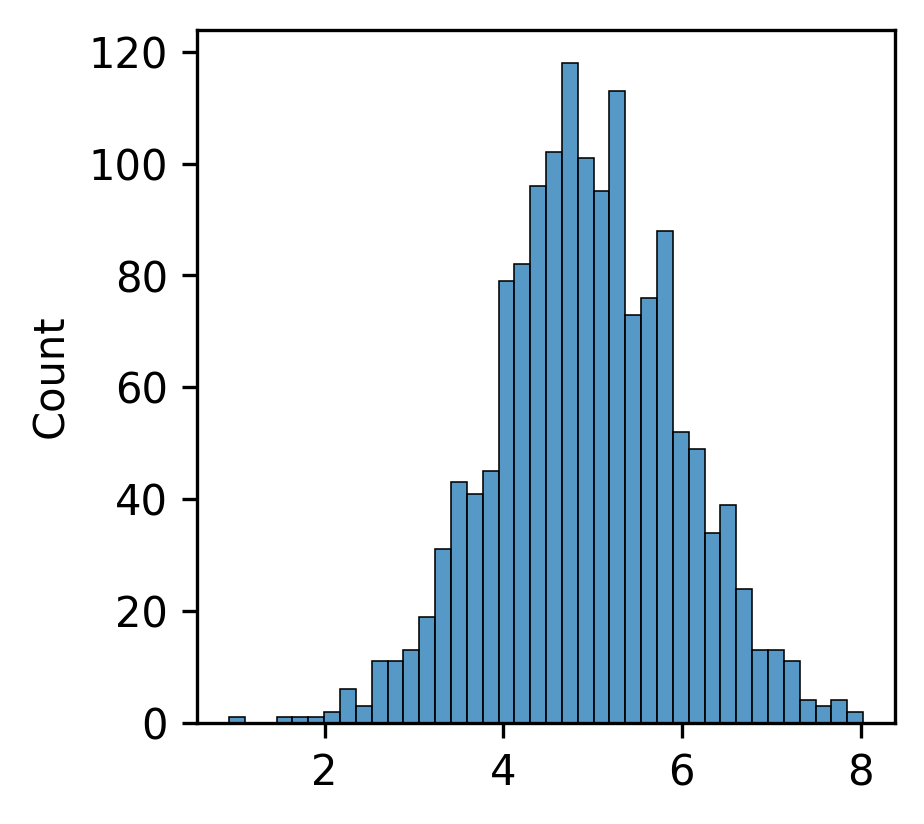

In [9]:
# generate random user income data.
user_income = (torch.randn(num_users) + 5).clamp(min=0)
# plot the histogram of user income.
plot_tensor(user_income)

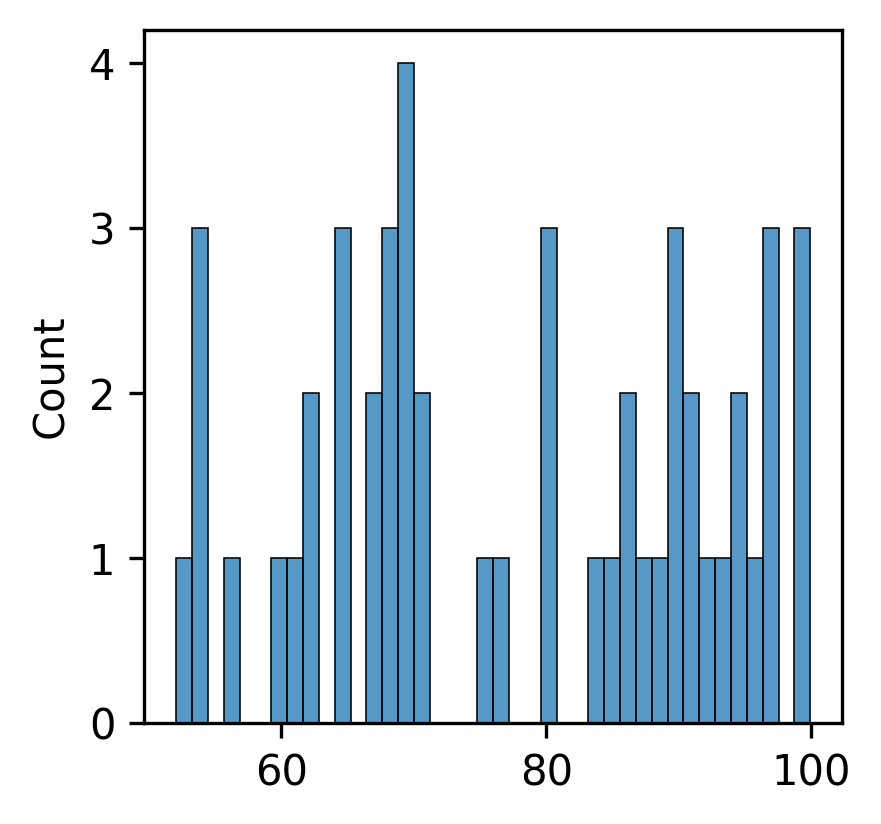

In [10]:
# generate item price data.
item_price = torch.rand(num_items) * 50 + 50
# plot distribution of item prices.
plot_tensor(item_price)
# WLOG, assign the first 25 items to be in the same category (category 1), and the rest to be in the other category (category 0).
item_bin_cate = torch.zeros(num_items).long()
item_bin_cate[:25] = 1

# combine both information into a tensor of shape (num_items, 2).
item_obs = torch.stack([item_price, item_bin_cate], dim=1)

## Generate Item-Specific Random Coefficients and Utilities.
In our first simulation case, the utility $\mu_{uis}$ is a function of user-income with item-specific coefficient.

$$
\mu_{uis} = \beta_i \times x^\text{user income}_u
$$

The item-specific coefficient $\beta_i$ is generated as a stochastic function of item prices. For high price items, income boost utility (e.g., luxury items). For low price items, low income boost utility. Please refer to the BEMB paper for a more detailed description of the simulation setup.

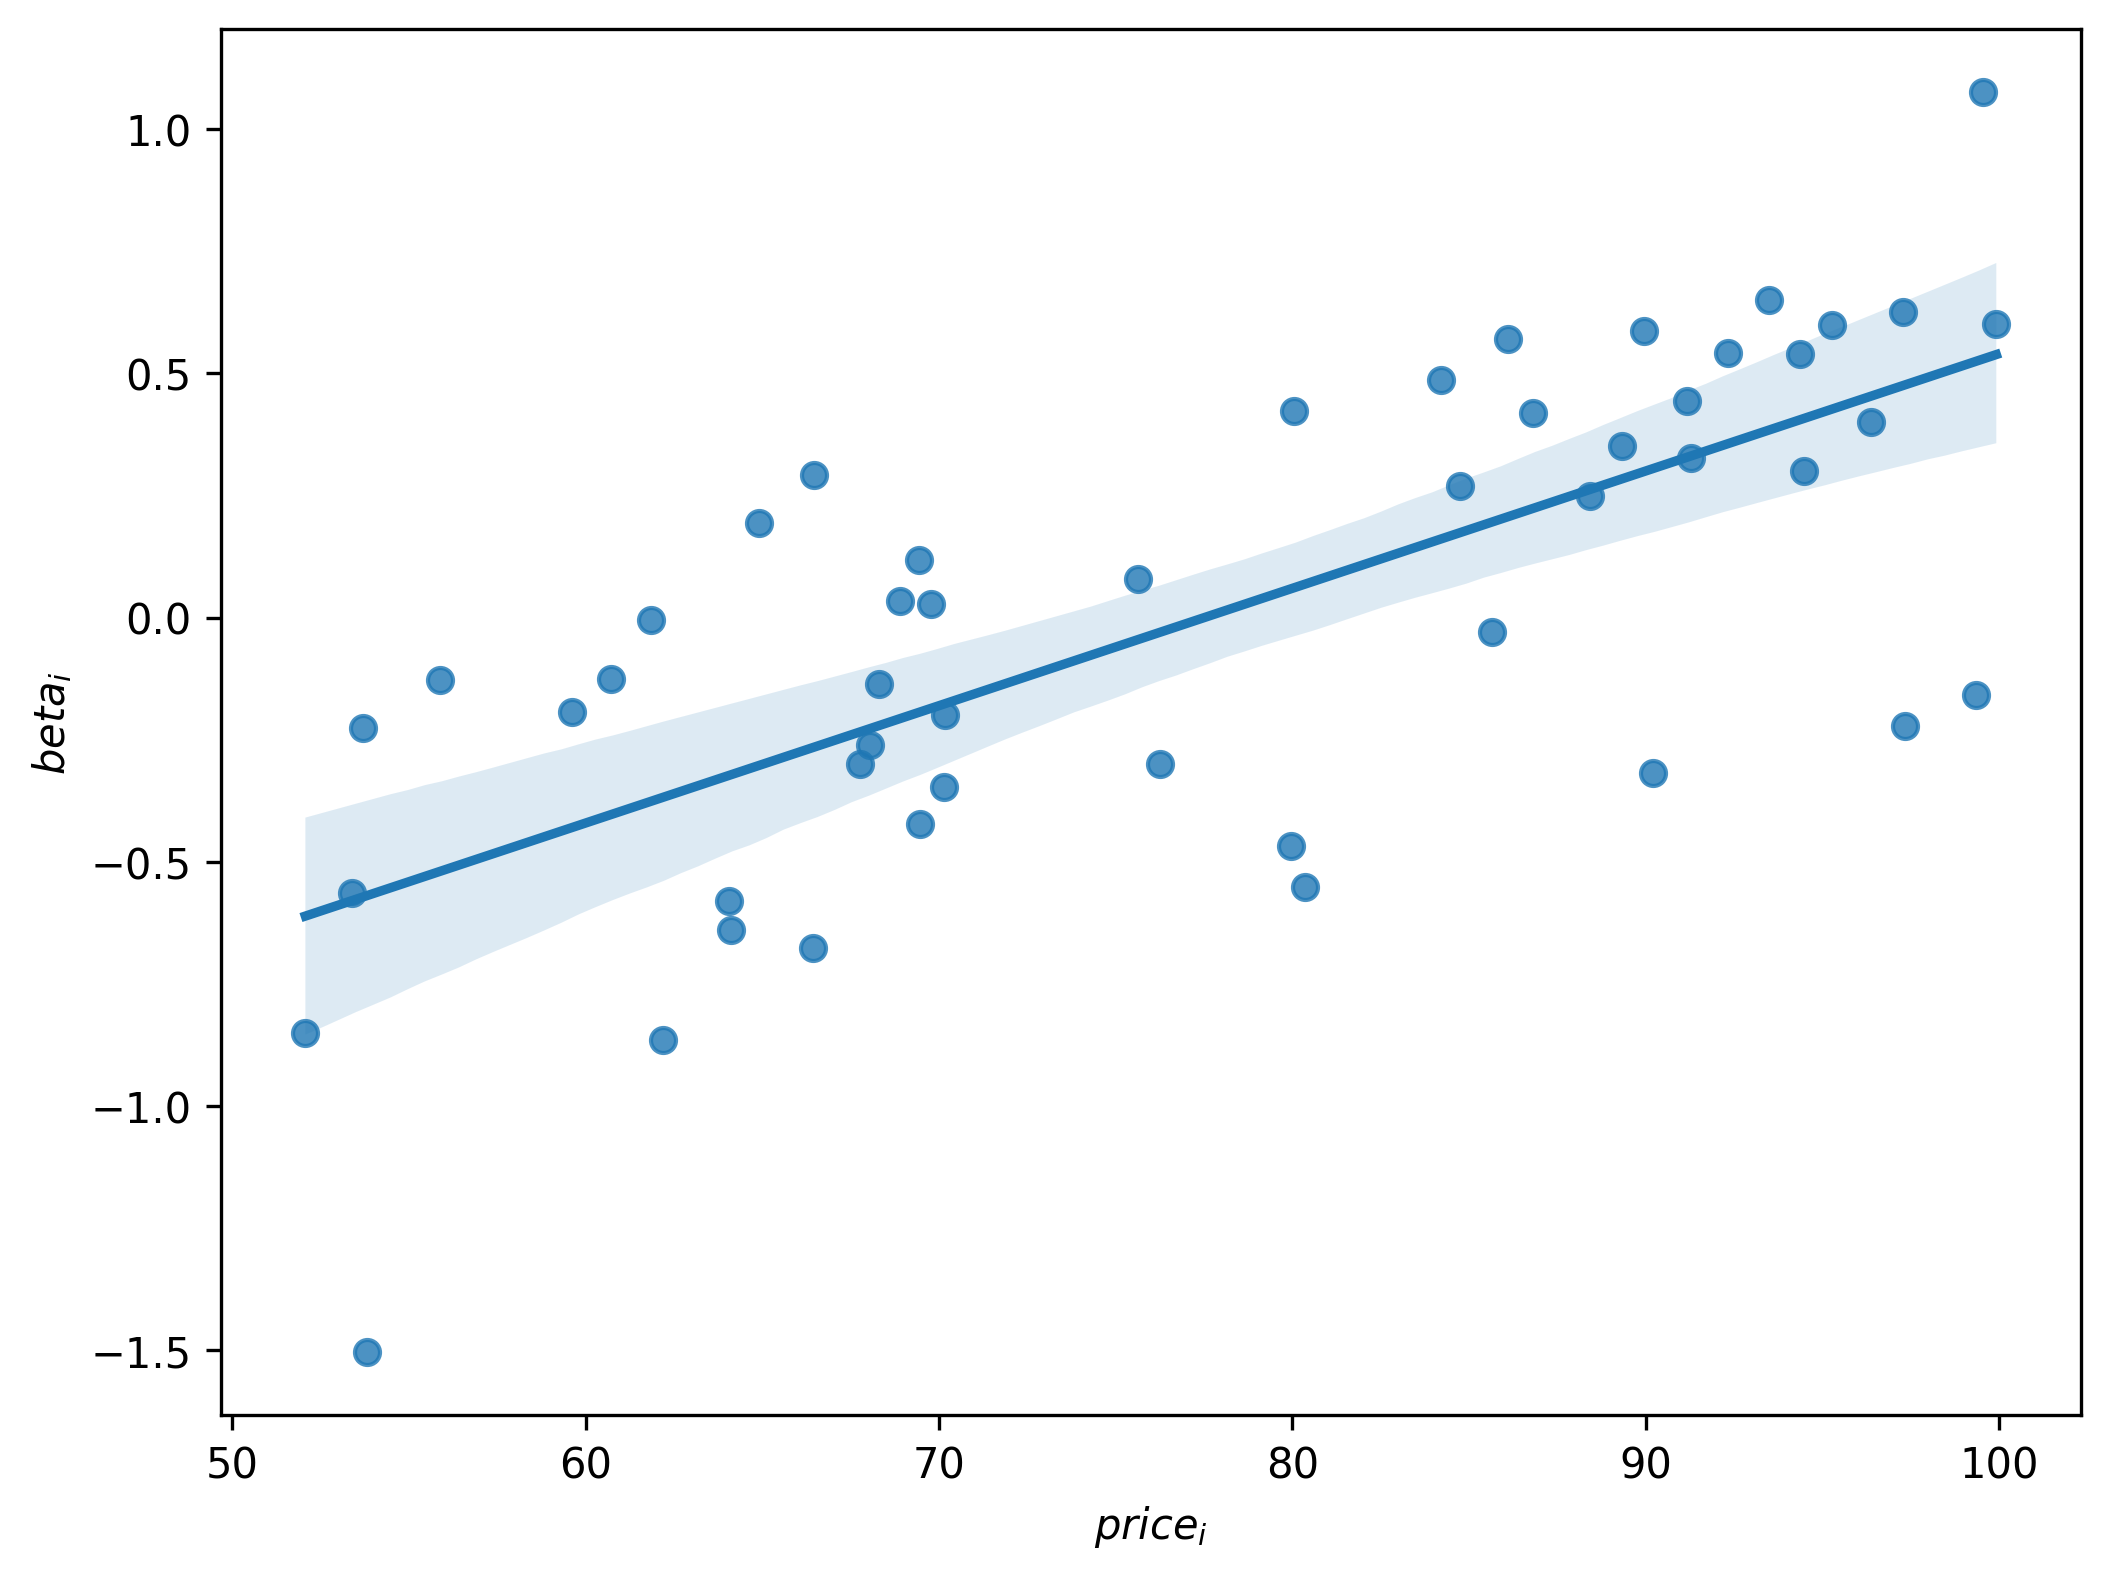

In [11]:
# generate $beta_i$ for simulation study.
scaled_price = (item_price - torch.min(item_price))/ (torch.max(item_price) - torch.min(item_price)) - 0.5
beta_item = torch.randn_like(scaled_price)*torch.std(scaled_price) + scaled_price

# plot the relationship between $price_i$ and $beta_i$.
fig, ax = plt.subplots(figsize=(8, 6), dpi=DPI)
sns.regplot(x=item_price.squeeze().numpy(), y=beta_item.numpy(), ax=ax)
ax.set_xlabel("$price_i$")
ax.set_ylabel("$beta_i$")
fig.savefig(os.path.join(OUTPUT_DIR, 'simulation_1_income_coefficients.png'), dpi=DPI, bbox_inches='tight')
fig.show()

In [12]:
# compute the utility $\mu_{uis}$ for each user $u$, item $i$, and session $s$.
# there is no session effect in this simulation study, hence $\mu_{uis}$ is the same for all $s$.
utility = torch.zeros(num_users, num_items, num_sessions)
for u in range(num_users):
    for i in range(num_items):
        for s in range(num_sessions):
            utility[u, i, s] = beta_item[i] * user_income[u]

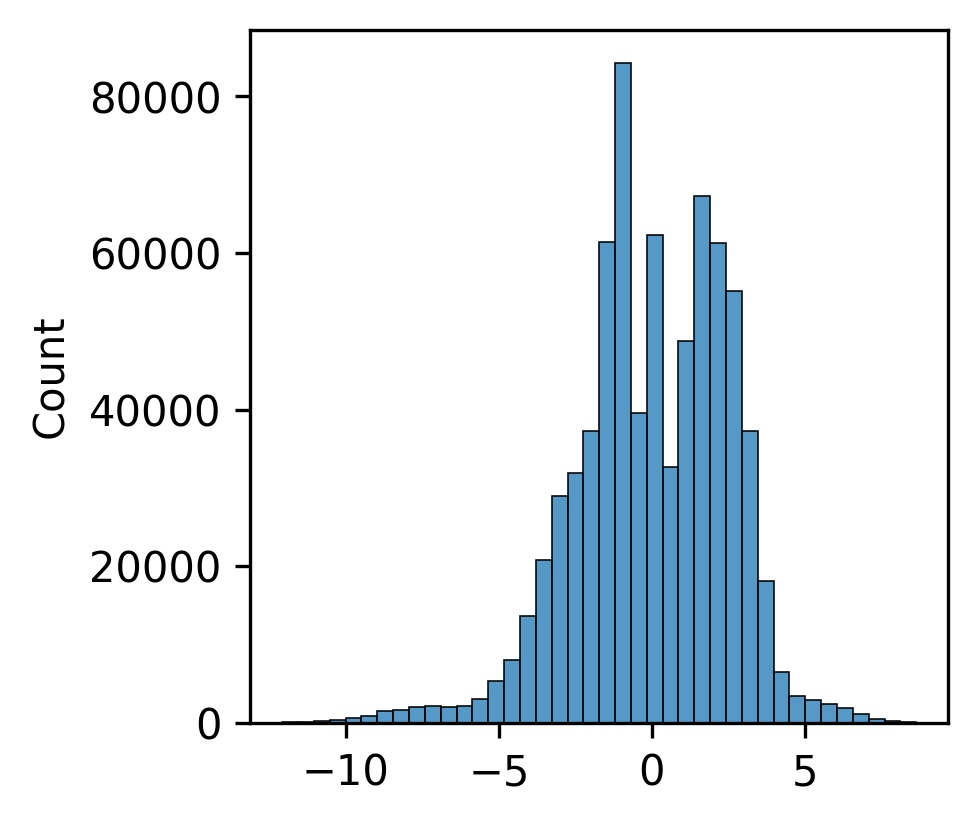

In [13]:
# distribution of U*I*S utility entries.
plot_tensor(utility)

## Generate Random Choices based on Utilities.

In [14]:
item_index = torch.empty(data_size, dtype=torch.long)
for idx in range(data_size):
    # get the user and session index corresponding to each choice record.
    u = user_index[idx]
    s = session_index[idx]
    utility_list = utility[u, :, s]  # list of utility values for all items in the session.
    p = torch.softmax(utility_list, dim=0).numpy()  # soft-max transform utilities to probabilities in multinominal distribution.
    assert abs(np.sum(p) - 1) < 1e-5  # check if the sum of probabilities is 1.
    # randomly choose an item from the multinominal distribution with probabilities p.
    item_index[idx] = np.random.choice(num_items, p=p)

In [15]:
def report_most_least_bought_items(item_index: torch.LongTensor):
    # report most bought and least bought items.
    vc = pd.DataFrame(data={"item": item_index.squeeze().numpy()}).value_counts(normalize=True).sort_values(ascending=False)
    print("Most bought item with their frequencies:")
    print(vc.head())
    print("Least bought item with their frequencies:")
    print(vc.tail())

## Build Choice Dataset
Please refer to our `torch-choice` paper for more details.

In [16]:
def split_dataset_into_train_val_test(D: ChoiceDataset) -> List[ChoiceDataset]:
    # split dataset into train, val, test.
    idx = np.random.permutation(len(D))
    train_size = int(0.8 * len(D))
    val_size = int(0.1 * len(D))
    train_idx = idx[:train_size]
    val_idx = idx[train_size: train_size + val_size]
    test_idx = idx[train_size + val_size:]

    dataset_list = [D[train_idx], D[val_idx], D[test_idx]]
    return dataset_list

In [17]:
dataset_1 = ChoiceDataset(user_index=user_index,
                        item_index=item_index,
                        session_index=session_index,
                        item_availability=None,  # everything is available.
                        # observables.
                        user_income=user_income.view(num_users, 1),
                        item_price=item_price.view(num_items, 1),
                        item_bin_cate=item_bin_cate).to(DEVICE)

print(dataset_1)

ChoiceDataset(label=[], item_index=[10000], user_index=[10000], session_index=[10000], item_availability=[], user_income=[1500, 1], item_price=[50, 1], item_bin_cate=[50], device=cuda:0)


## Fit A Model

In [18]:
# def fit_model(obs2prior: bool):
LATENT_DIM = 10  # the dimension of alpha and theta.
bemb = LitBEMBFlex(
    model_optimizer="Adam",
    learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
    pred_item=True,  # let the model predict item_index, don't change this one.
    num_seeds=128,  # number of Monte Carlo samples for estimating the ELBO.
    utility_formula='beta_item * user_income',  # the utility formula.
    num_users=num_users,
    num_items=num_items,
    trace_log_q=True,
    # whether to turn on obs2prior for each parameter.
    obs2prior_dict={'beta_item': False},
    # the dimension of beta_item, which is 1.
    coef_dim_dict={'beta_item': 1},
)

# use GPU if available.
bemb = bemb.to(DEVICE)
    
# use the provided run helper to train the model.
# we set batch size to be 5% of the data size, and train the model for 10 epochs.
# there would be 20*10=200 gradient update steps in total.
bemb = bemb.fit_model(
    split_dataset_into_train_val_test(dataset_1),
    batch_size=256, num_epochs=3, num_workers=0, device=DEVICE, enable_progress_bar=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 100   
-----------------------------------
100       Trainable params
0         Non-trainable params
100       Total params
0.000     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['beta_item'], 'observable': 'user_income'}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = beta_item * user_income
Total number of parameters: 100.
With the following coefficients:
ModuleDict(
  (beta_item): BayesianCoefficient(num_classes=50, dimension=1, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(label=[], item_index=[8000], user_index=[8000], session_index=[8000], item_availability=[], user_income=[1500, 1], item_price=[50, 1], item_bin_cate=[50], device=cuda:0)
[Validation dataset] ChoiceDataset(label=[], item_index=[1000], user_index=[1000], session_index=[1000], item_availability=[], user_income=[1500, 1], item_price=[50, 1], item_bin_cate=[50], device=cuda:0)
[Testing dataset] ChoiceDataset(label=[], item_index=[1000], user_index=[1000], session_index=[1000], ite

/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.se

time taken: 1.3115406036376953
==================== test performance ====================


/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.452           │
│          test_ll          │    -3.2950756352357566    │
└───────────────────────────┴───────────────────────────┘

## Comparison between $\beta_i$ and $\hat{\beta}_i$ for items.

real.shape=(50,), pred.shape=(50,)


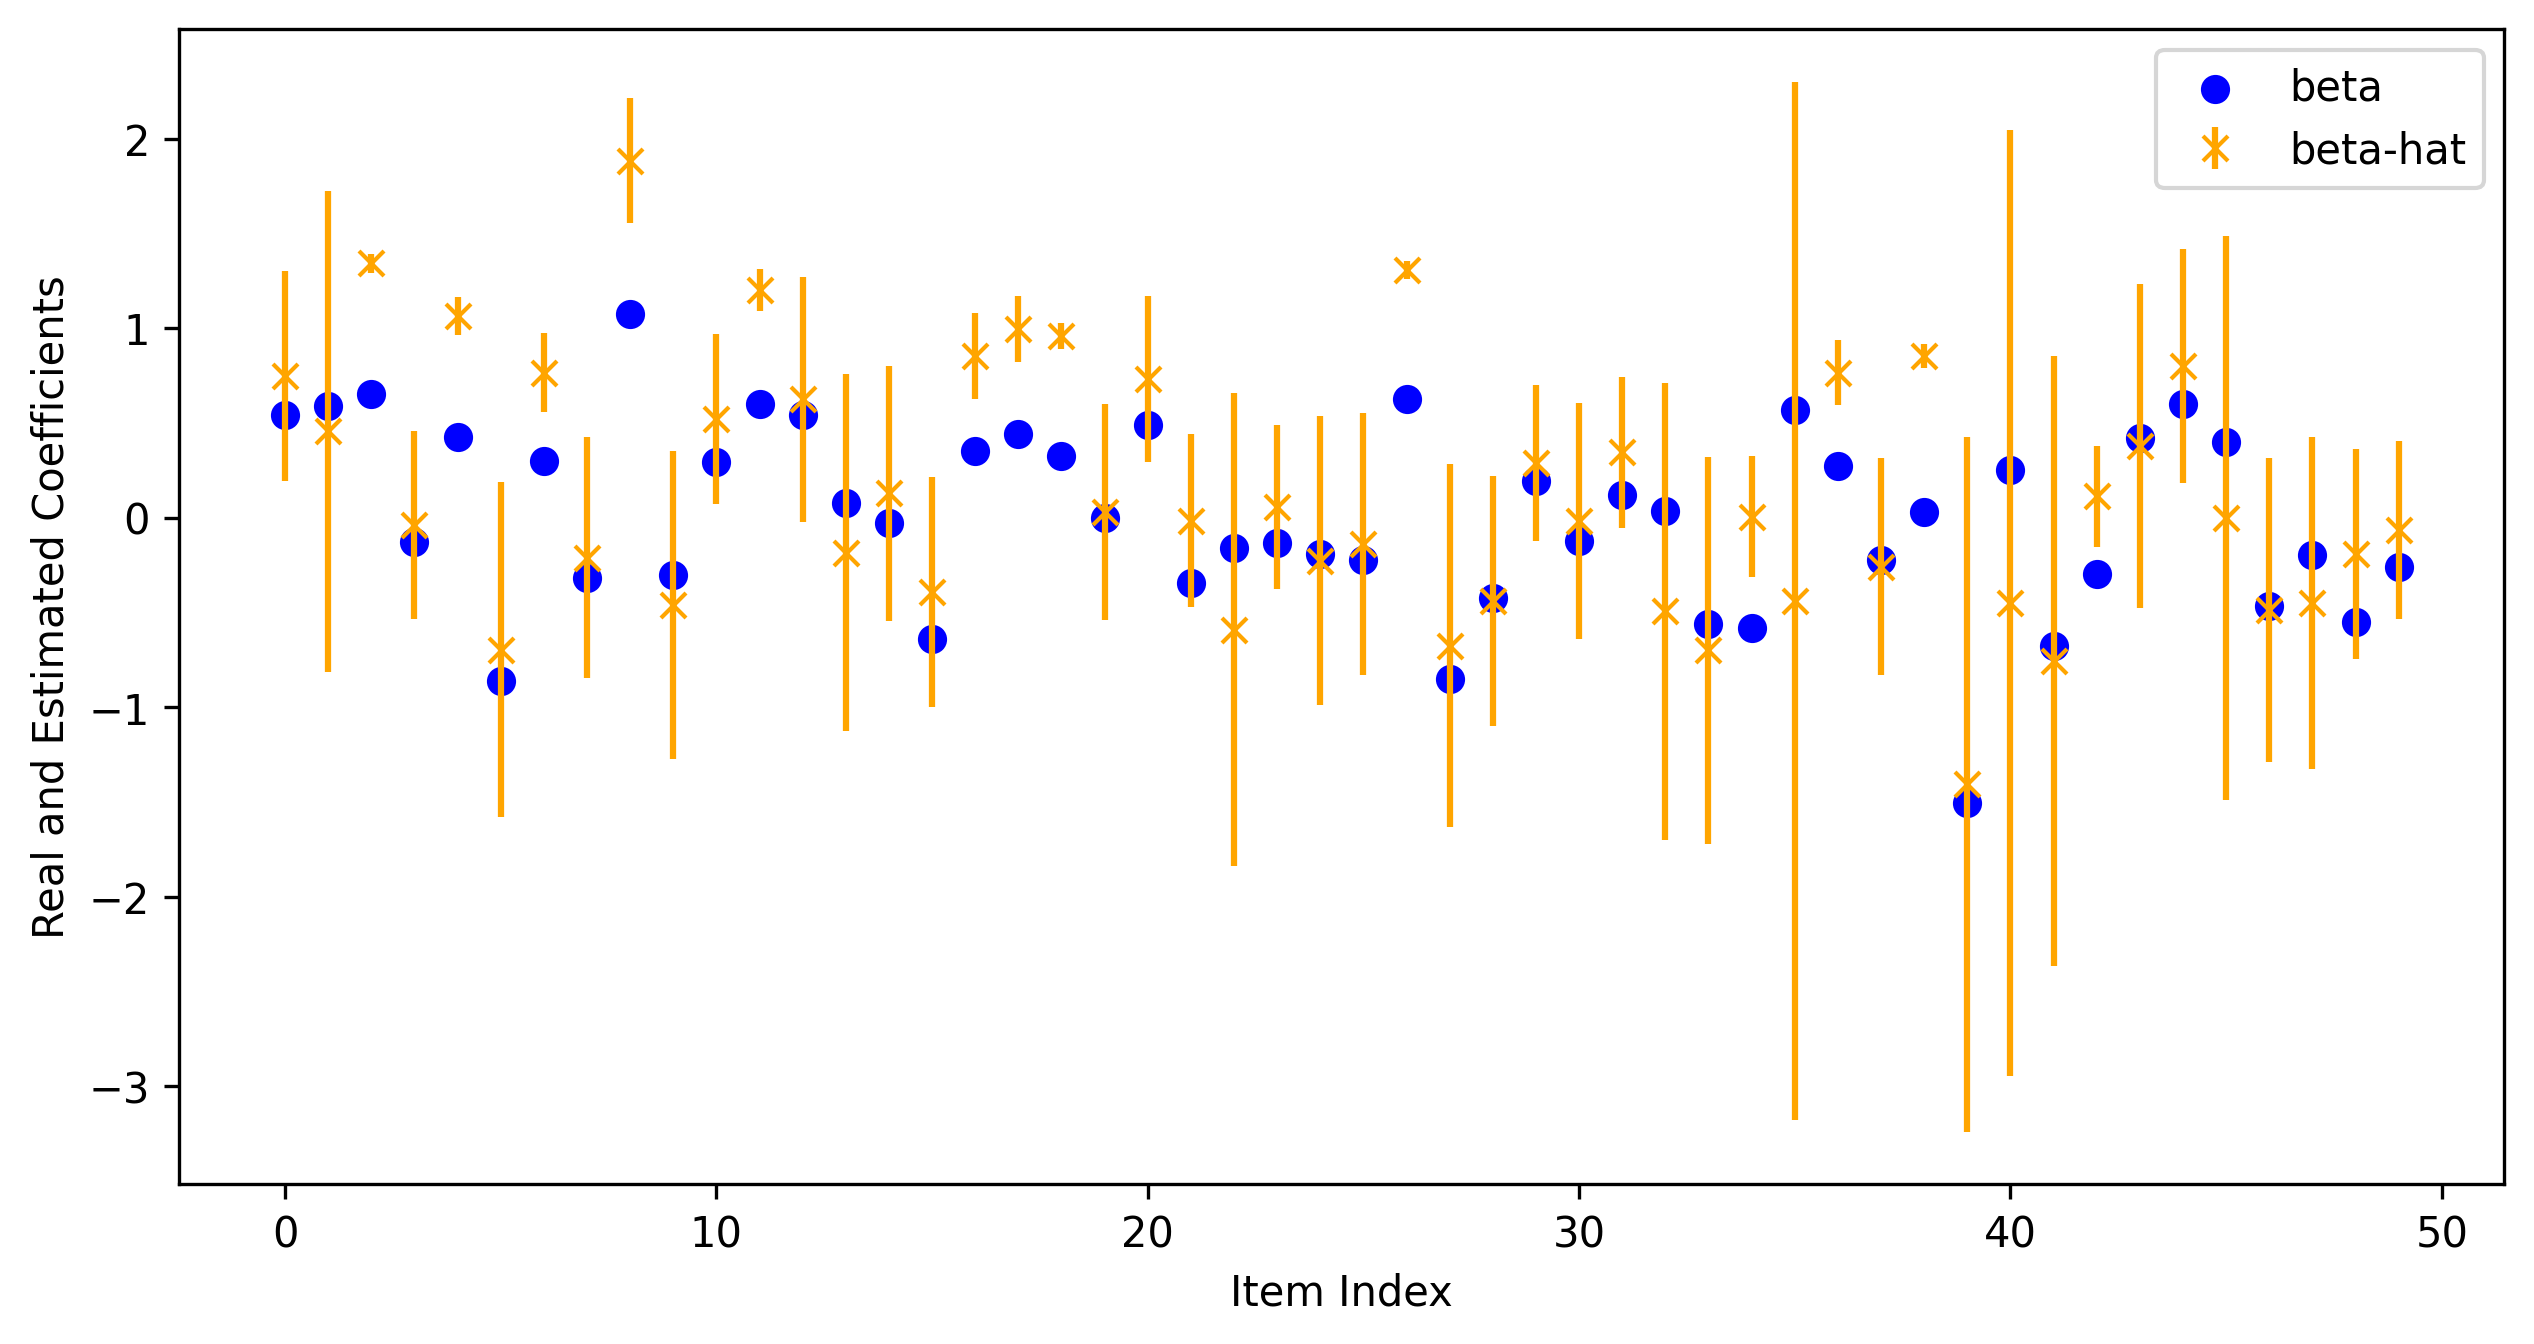

In [19]:
# actual beta_i's
real = beta_item.squeeze().numpy()
# prediction from the fitted variational distribution.
pred = bemb.state_dict()["coef_dict.beta_item.variational_mean_flexible"].squeeze().numpy()
err = 1.96 * bemb.state_dict()["coef_dict.beta_item.variational_logstd"].squeeze().exp()

print(f"{real.shape=:}, {pred.shape=:}")
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)
ax.scatter(np.arange(num_items), real, label="beta", marker="o", color="blue")
ax.errorbar(np.arange(num_items), y=pred, yerr=err, label="beta-hat", marker="x", linestyle='none', color="orange")

ax.set_xlabel("Item Index")
ax.set_ylabel("Real and Estimated Coefficients")
ax.legend()
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_1_beta_hat.png"), dpi=DPI, bbox_inches="tight")
fig.show()

# Simulation Study 2: More Complicated Item-Specific Effects (Obs2Prior)

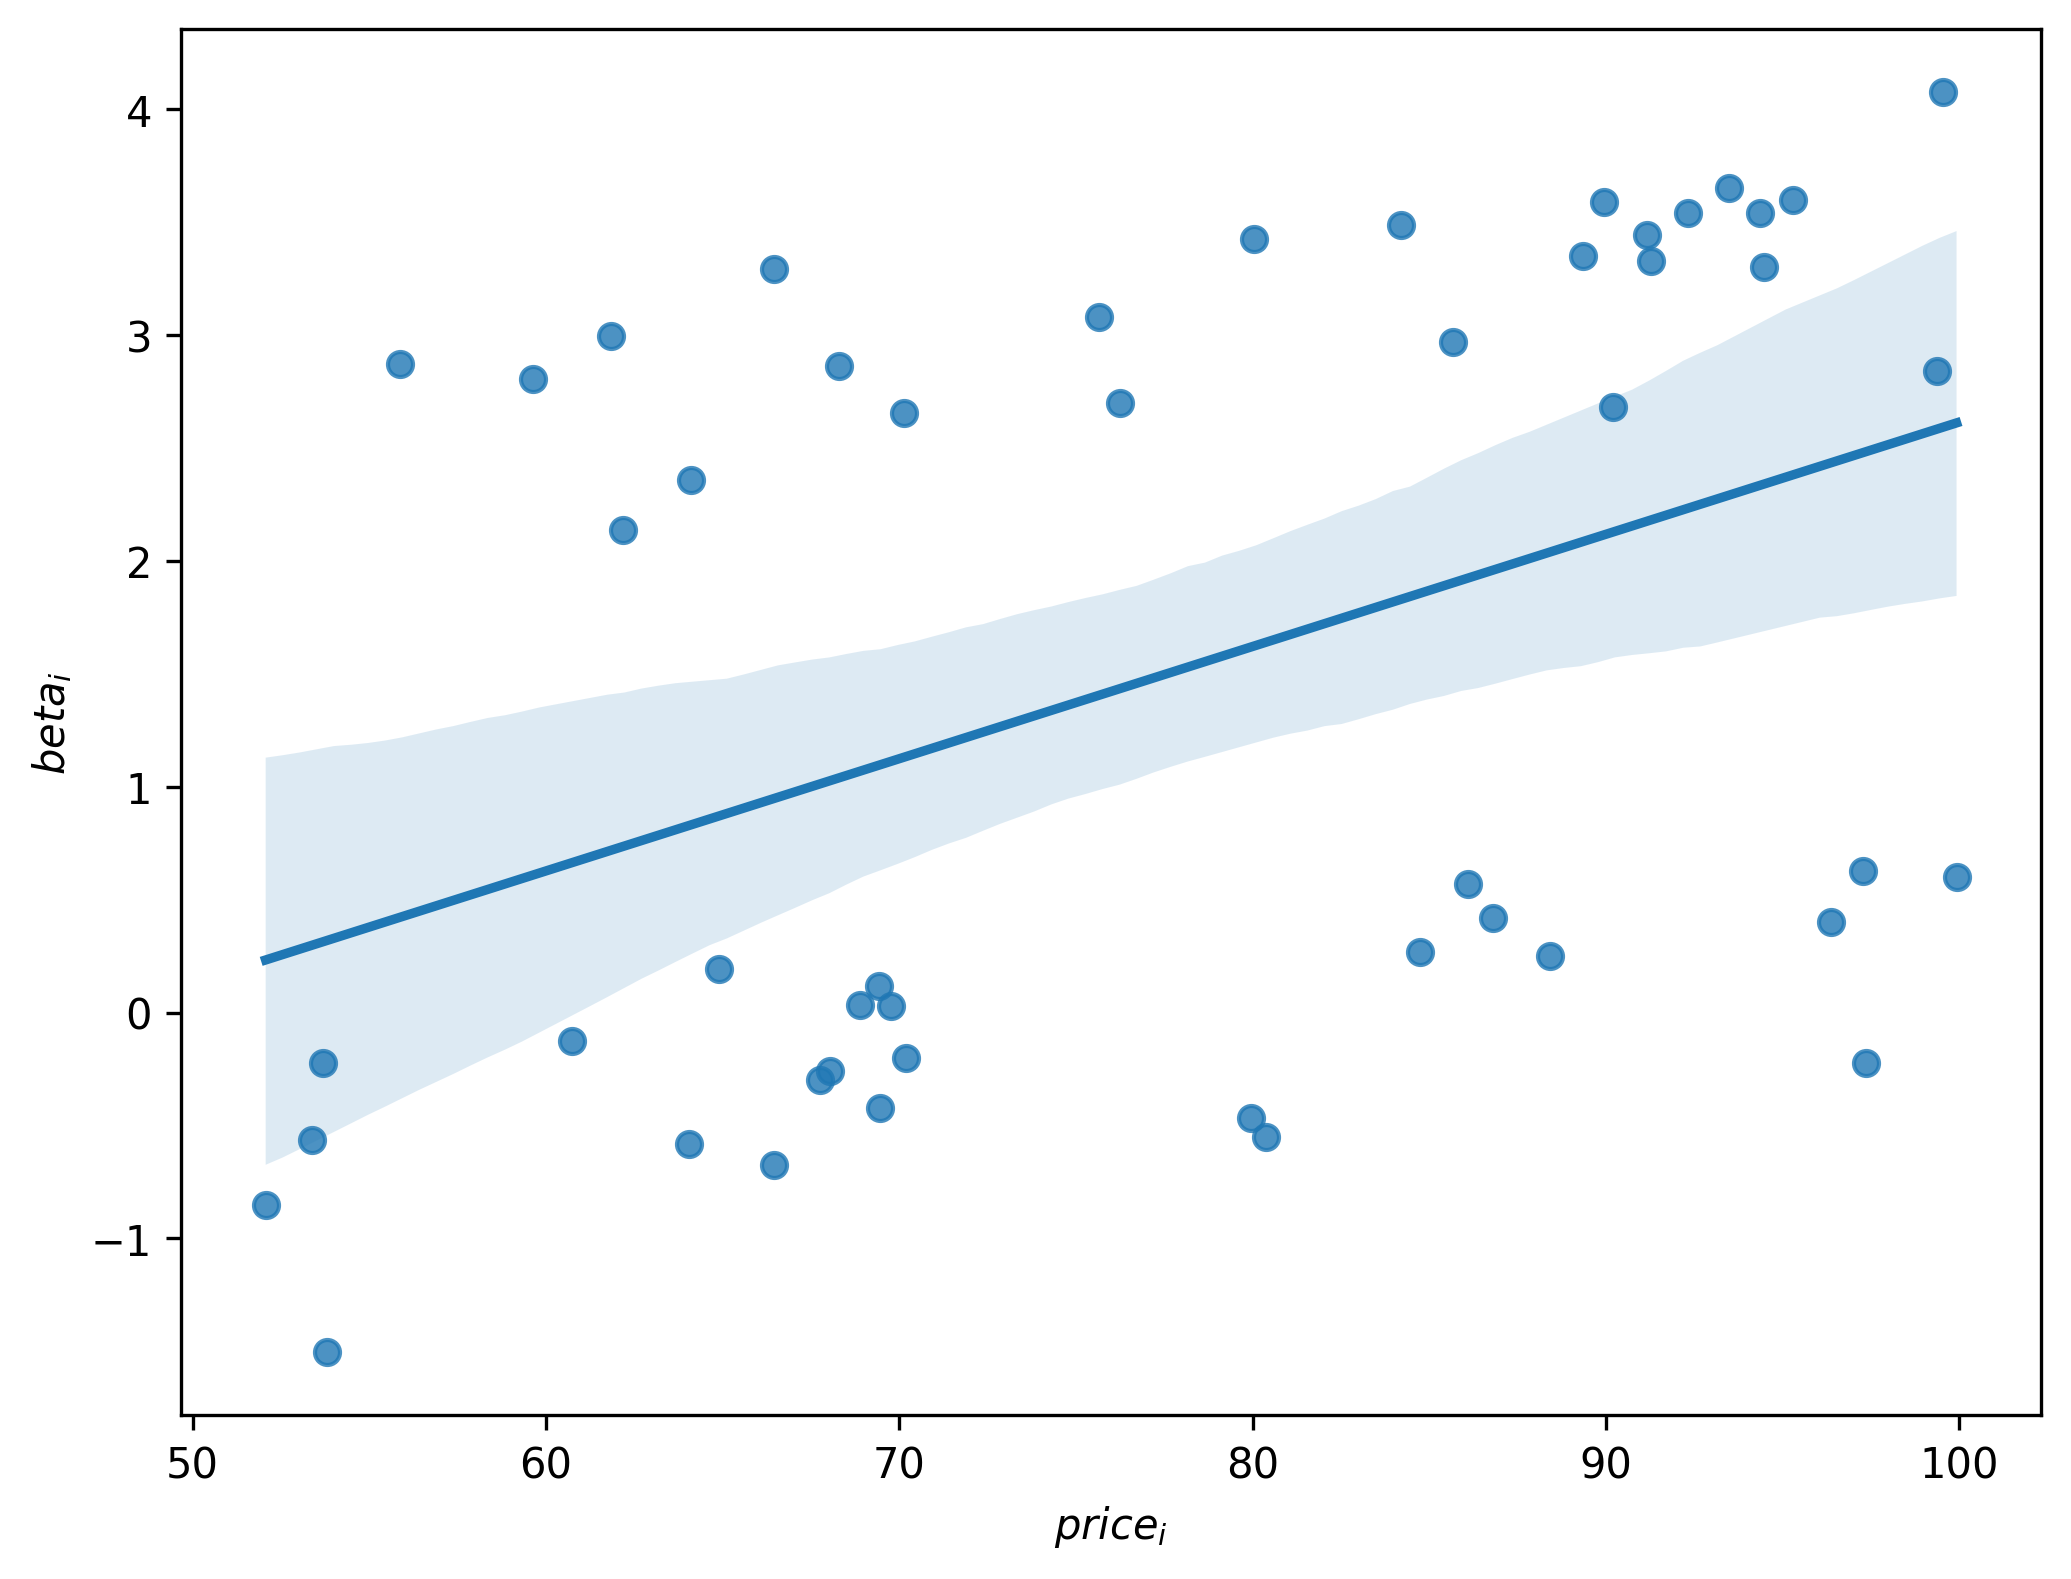

In [20]:
# modify the beta_item based on the item category.
for i in range(num_items):
    if item_bin_cate[i] == 1:
        beta_item[i] = beta_item[i] + 3

fig, ax = plt.subplots(figsize=(8, 6), dpi=DPI)
sns.regplot(x=item_price.squeeze().numpy(), y=beta_item.numpy(), ax=ax)
ax.set_xlabel("$price_i$")
ax.set_ylabel("$beta_i$")
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_2_income_coefficients.png"), dpi=DPI, bbox_inches='tight')
fig.show()

In [21]:
# recompute the utility matrix using the new coefficient.
utility = torch.zeros(num_users, num_items, num_sessions)
for u in tqdm(range(num_users)):
    for i in range(num_items):
        for s in range(num_sessions):
            utility[u, i, s] = beta_item[i] * user_income[u]
# generate choices.
item_index = torch.empty(data_size, dtype=torch.long)
for idx in tqdm(range(data_size)):
    u = user_index[idx]
    s = session_index[idx]
    utility_list = utility[u, :, s]
    p = torch.softmax(utility_list, dim=0).numpy()
    item_index[idx] = np.random.choice(num_items, p=p)

100%|██████████| 10000/10000 [00:00<00:00, 27781.87it/s]


In [22]:
report_most_least_bought_items(item_index)

Most bought item with their frequencies:
item
8       0.5743
2       0.0692
11      0.0554
1       0.0510
12      0.0446
dtype: float64
Least bought item with their frequencies:
item
24      0.0016
21      0.0013
9       0.0010
7       0.0010
15      0.0002
dtype: float64


In [23]:
dataset_2 = ChoiceDataset(user_index=user_index,
                        item_index=item_index,
                        session_index=session_index,
                        item_availability=None,  # everything is available.
                        # observables.
                        user_income=user_income.view(num_users, 1),
                        item_price=item_price.view(num_items, 1),
                        item_bin_cate=item_bin_cate.view(num_items, 1),
                        item_obs=item_obs
                        ).to(DEVICE)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 104   
-----------------------------------
104       Trainable params
0         Non-trainable params
104       Total params
0.000     Total estimated model params size (MB)
/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, do

BEMB: utility formula parsed:
[{'coefficient': ['beta_item'], 'observable': 'user_income'}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = beta_item * user_income
Total number of parameters: 104.
With the following coefficients:
ModuleDict(
  (beta_item): BayesianCoefficient(num_classes=50, dimension=1, prior=N(H*X_obs(H shape=torch.Size([1, 2]), X_obs shape=2), Ix1.0))
)
[]
Optimizer: Adam, Learning rate: 0.3
==================== data set received ====================
[Training dataset] ChoiceDataset(label=[], item_index=[8000], user_index=[8000], session_index=[8000], item_availability=[], user_income=[1500, 1], item_price=[50, 1], item_bin_cate=[50, 1], item_obs=[50, 2], device=cuda:0)
[Validation dataset] ChoiceDataset(label=[], item_index=[1000], user_index=[1000], session_index=[1000], item_availability=[], user_income=[1500, 1], item_price=[50, 1], item_bin_cate=[50, 1], item_obs=[50, 2], device=cuda:0)
[Testing da

`Trainer.fit` stopped: `max_epochs=40` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


time taken: 15.171826839447021
==================== test performance ====================


/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.573           │
│          test_ll          │    -1.775816478602588     │
└───────────────────────────┴───────────────────────────┘

real.shape=(50,), pred.shape=(50,)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 100   
-----------------------------------
100       Trainable params
0         Non-trainable params
100       Total params
0.000     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['beta_item'], 'observable': 'user_income'}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = beta_item * user_income
Total number of parameters: 100.
With the following coefficients:
ModuleDict(
  (beta_item): BayesianCoefficient(num_classes=50, dimension=1, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.3
==================== data set received ====================
[Training dataset] ChoiceDataset(label=[], item_index=[8000], user_index=[8000], session_index=[8000], item_availability=[], user_income=[1500, 1], item_price=[50, 1], item_bin_cate=[50, 1], item_obs=[50, 2], device=cuda:0)
[Validation dataset] ChoiceDataset(label=[], item_index=[1000], user_index=[1000], session_index=[1000], item_availability=[], user_income=[1500, 1], item_price=[50, 1], item_bin_cate=[50, 1], item_obs=[50, 2], device=cuda:0)
[Testing dataset] ChoiceDataset(label=[], item_index=[1000], use

/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=40` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.s

time taken: 13.723082304000854
==================== test performance ====================


/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.603           │
│          test_ll          │     -1.76185211494565     │
└───────────────────────────┴───────────────────────────┘

real.shape=(50,), pred.shape=(50,)


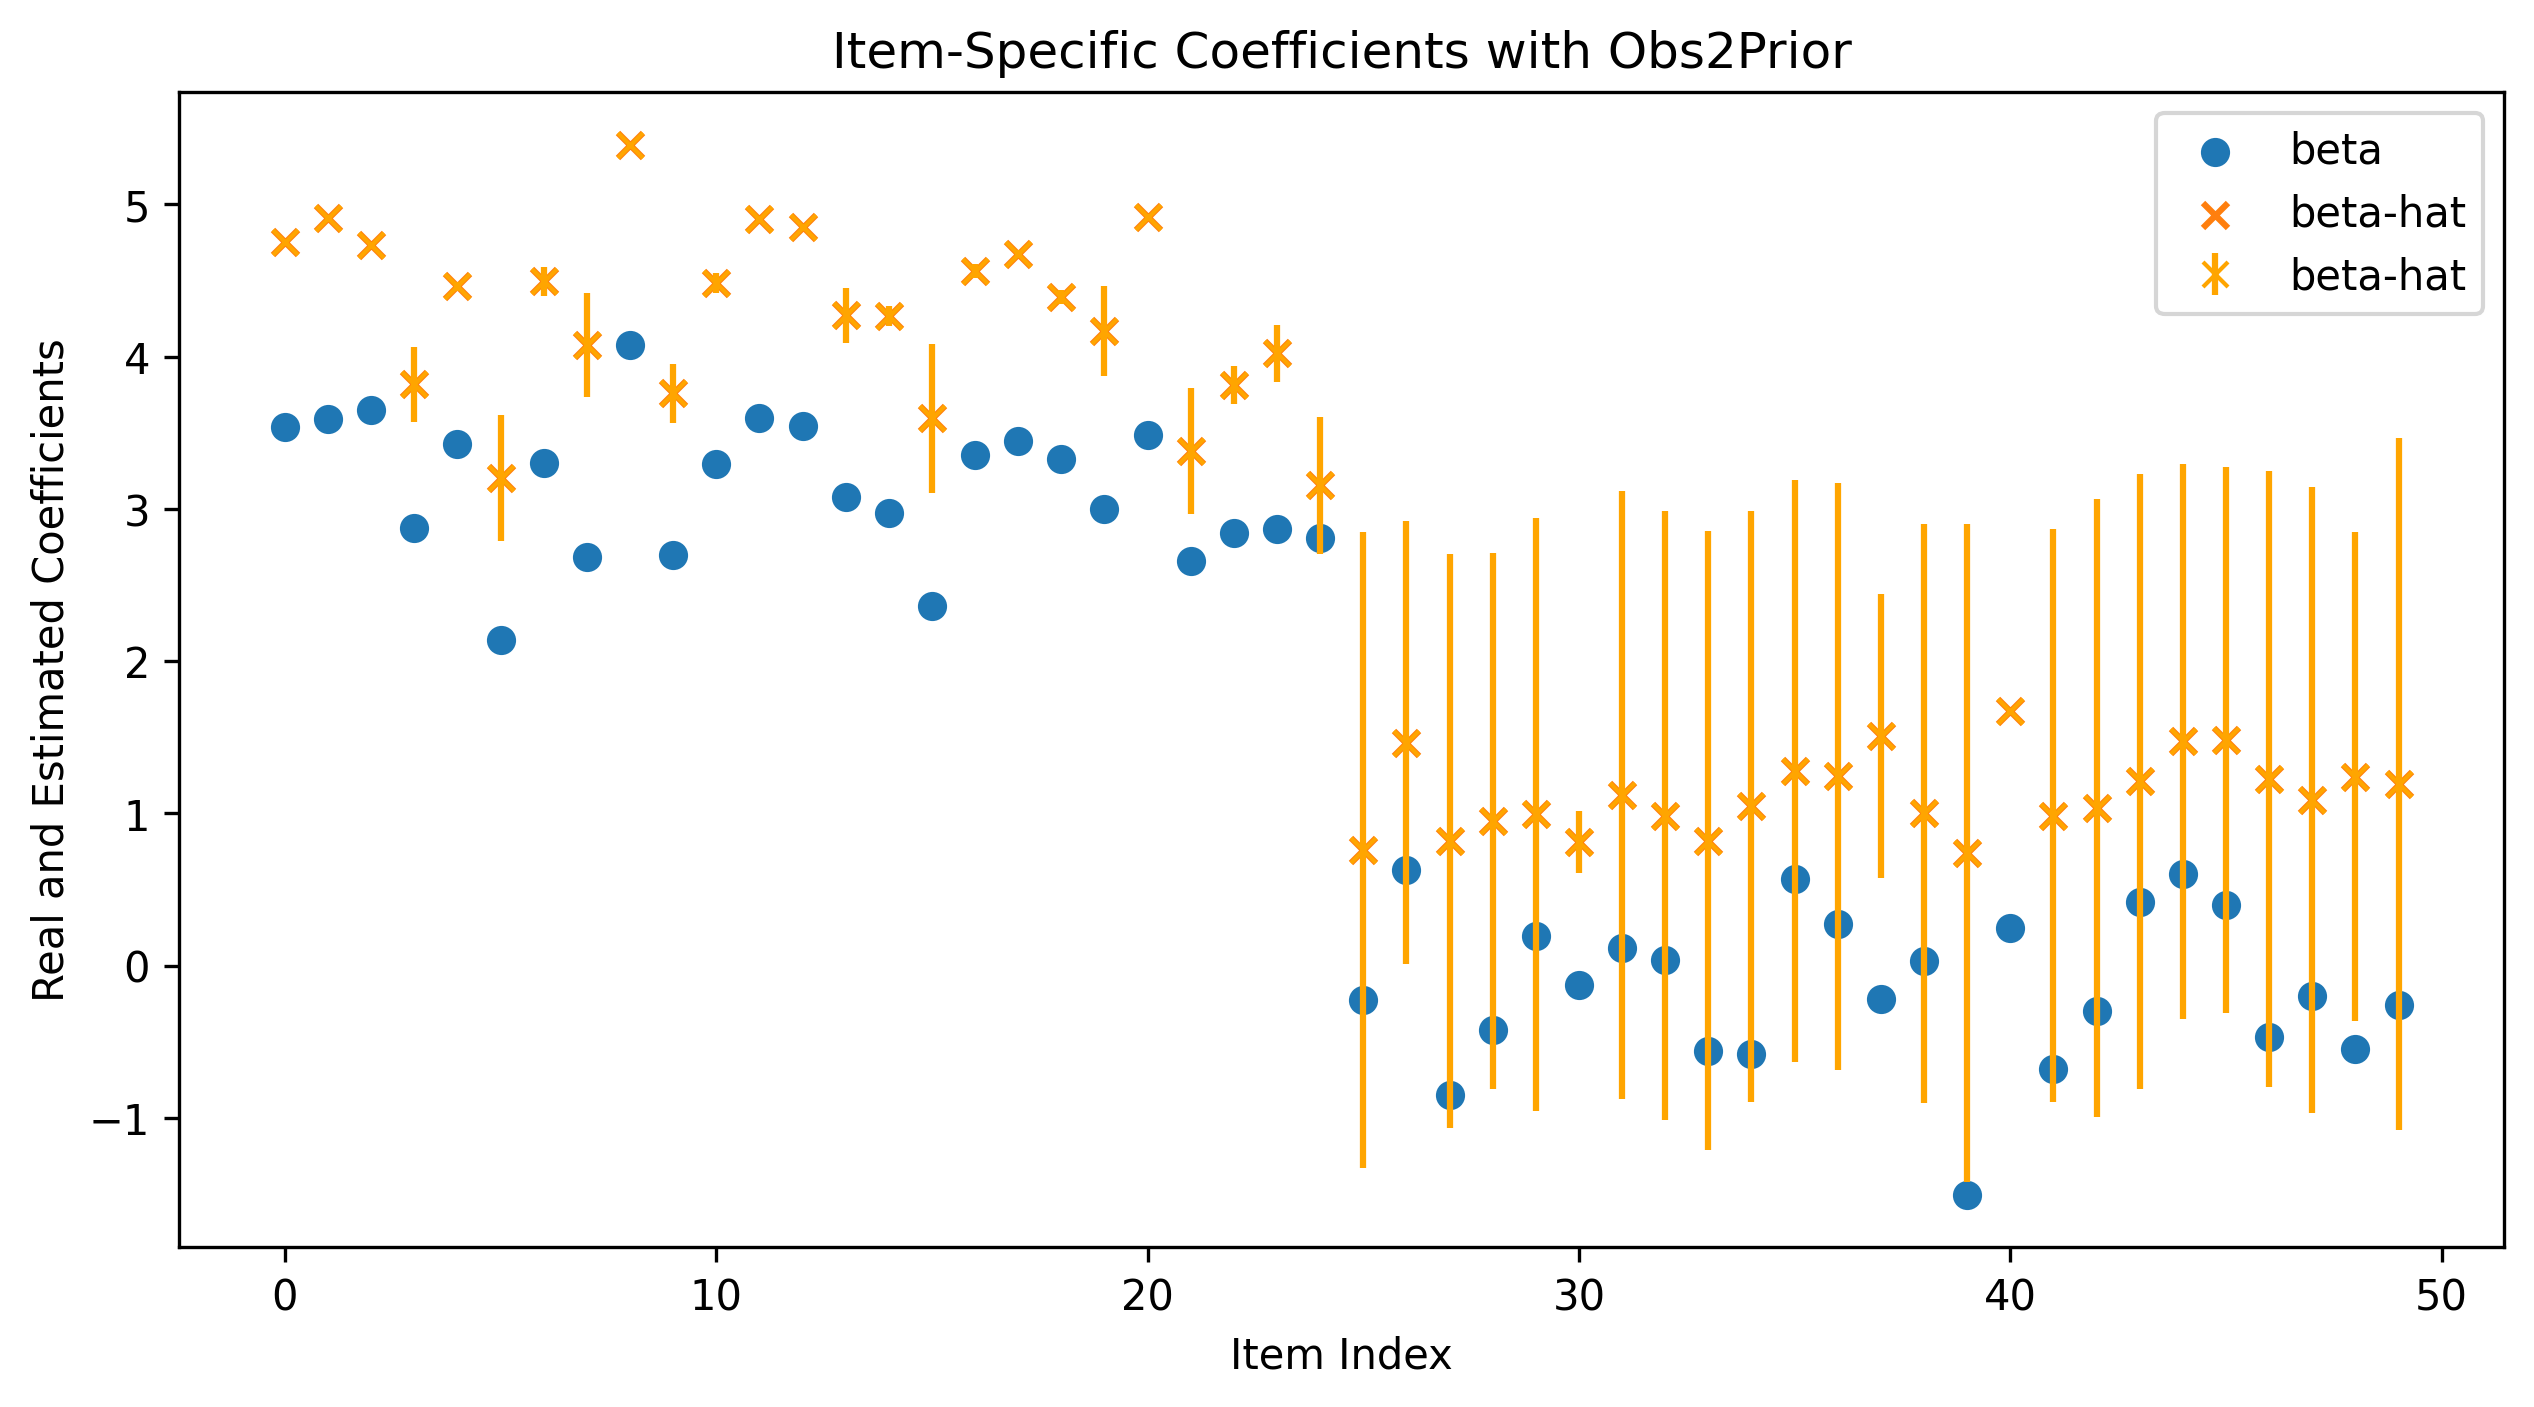

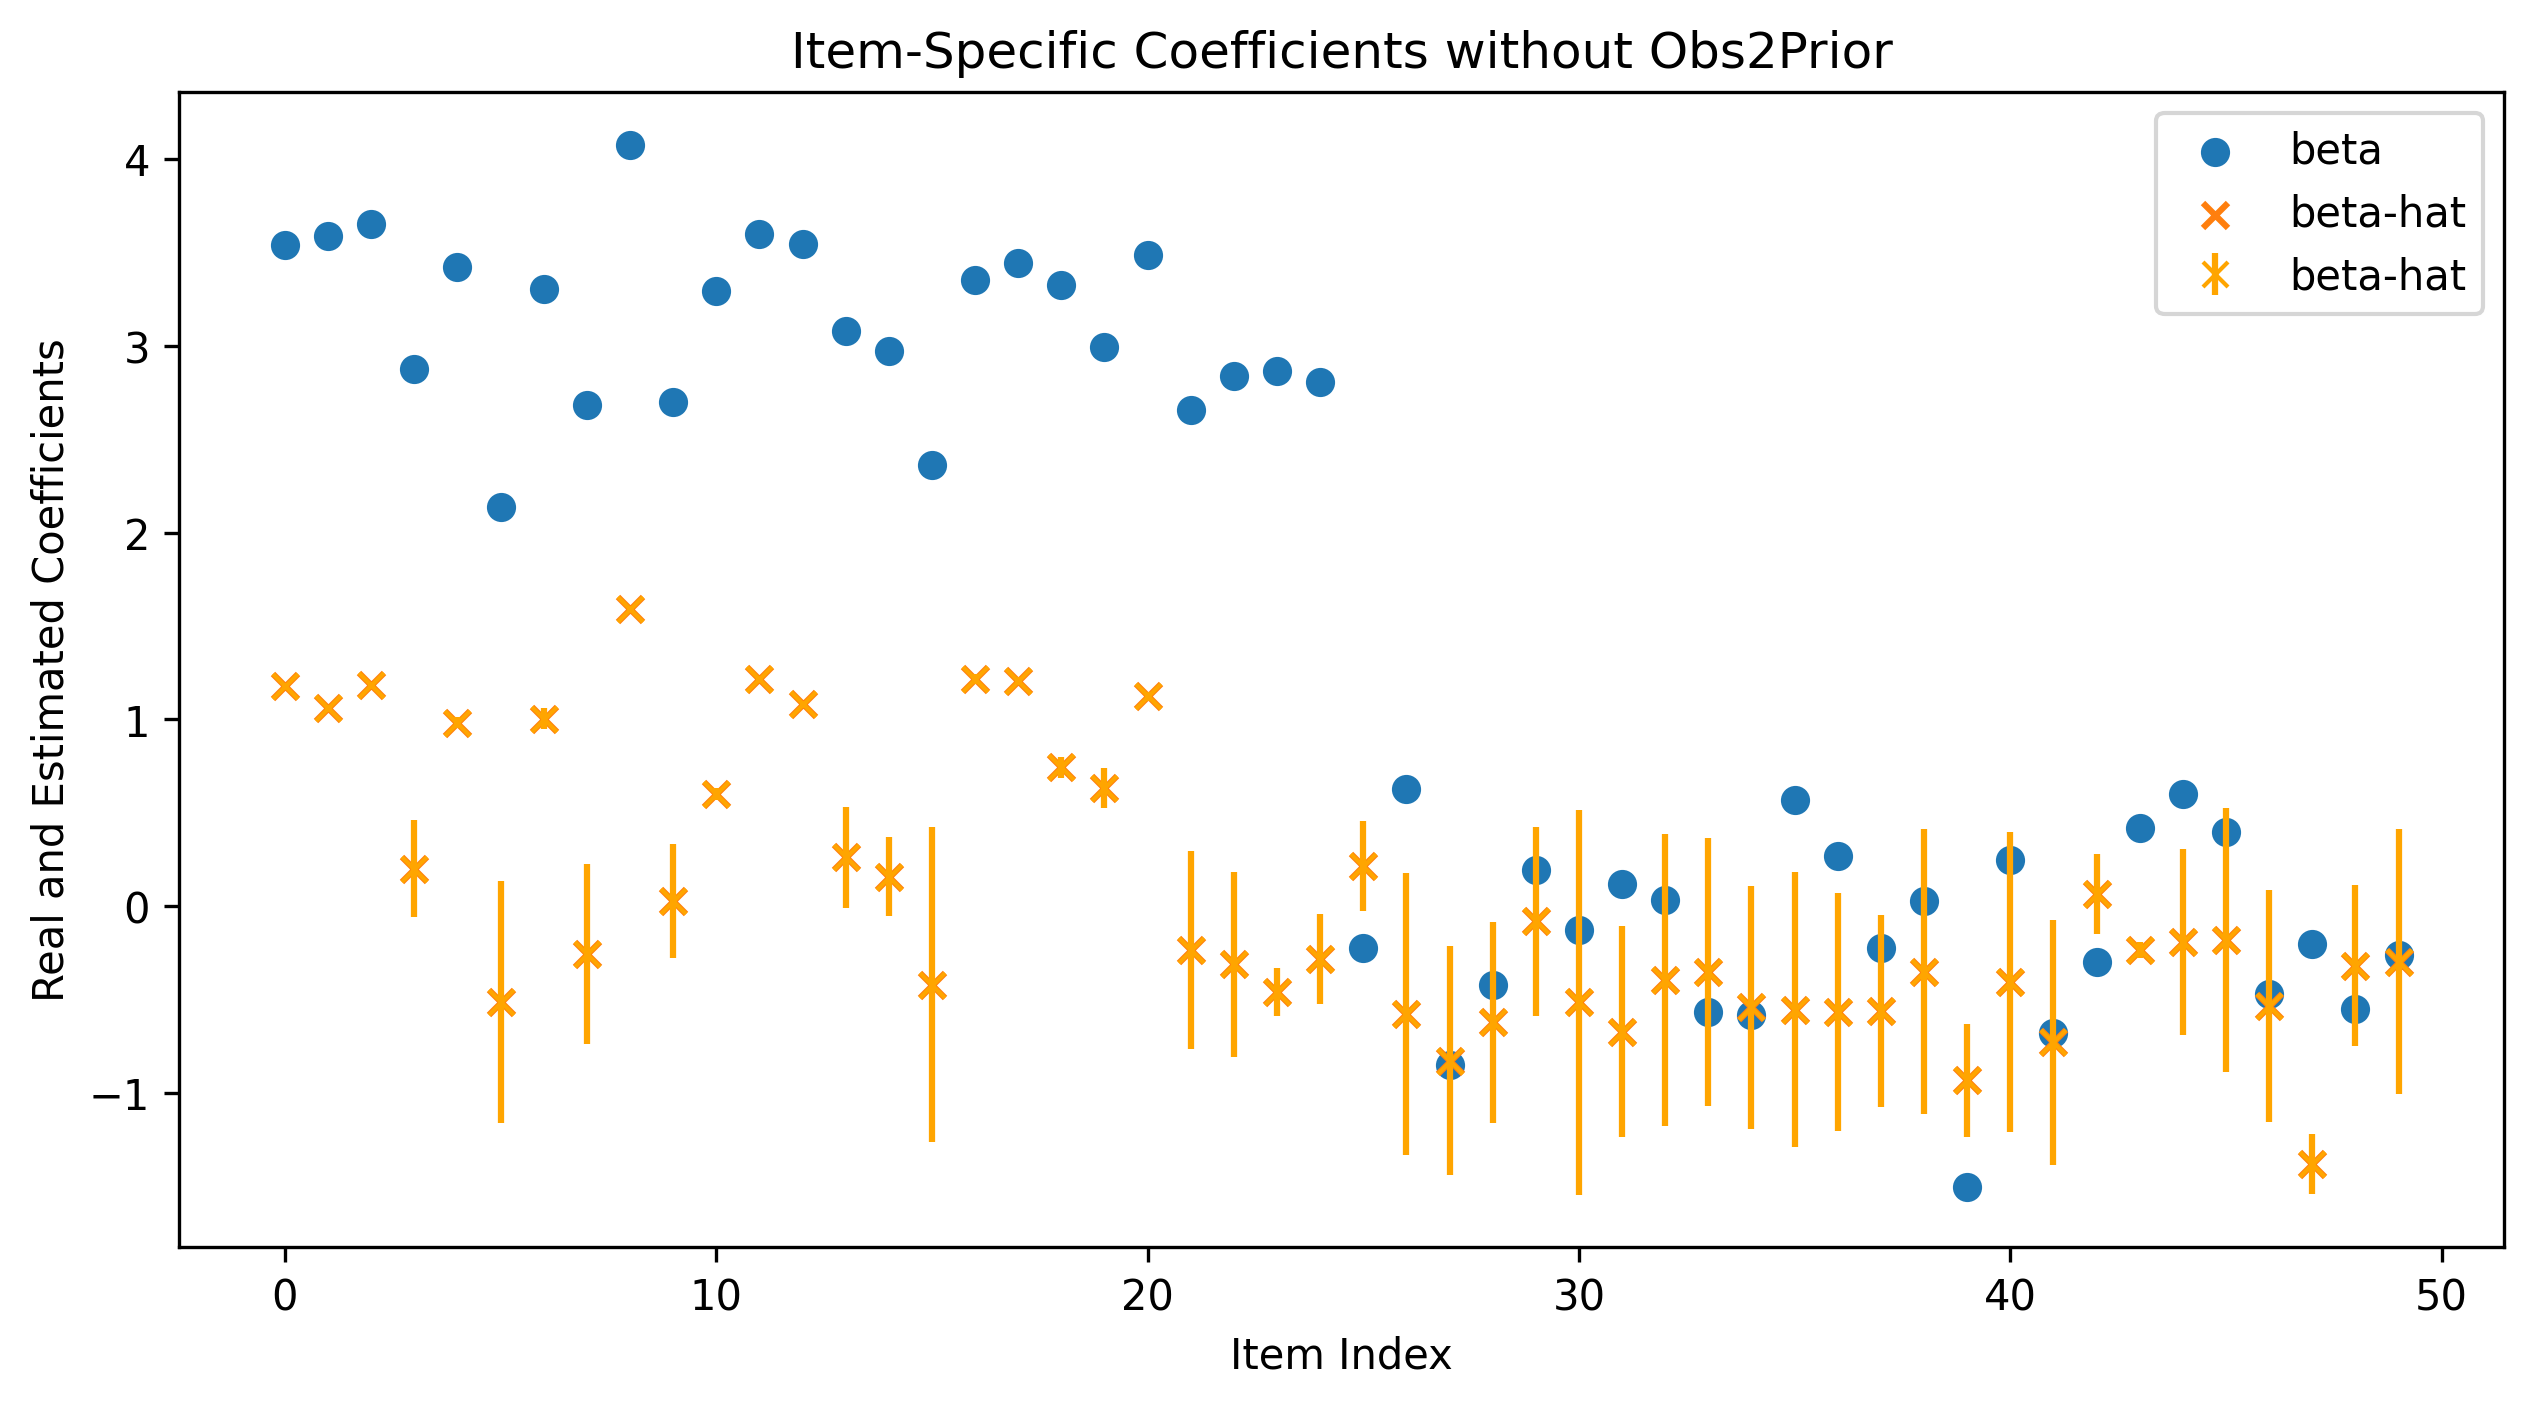

In [24]:
# run two versions of the model with and without obs2prior.
for enable_obs2prior in [True, False]:
    # def fit_model(obs2prior: bool):
    LATENT_DIM = 10  # the dimension of alpha and theta.
    bemb = LitBEMBFlex(
        model_optimizer="Adam",
        learning_rate=0.3,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO.
        utility_formula='beta_item * user_income',  # the utility formula.
        num_users=num_users,
        num_items=num_items,
        trace_log_q=True,
        # num_user_obs=dataset.user_obs.shape[1],
        num_item_obs=dataset_2.item_obs.shape[1],
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'beta_item': enable_obs2prior},
        # the dimension of latents, since the utility is an inner product of theta and alpha, they should have
        # the same dimension.
        coef_dim_dict={'beta_item': 1},
    )

    # use GPU if available.
    bemb = bemb.to(DEVICE)
 
    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb = bemb.fit_model(split_dataset_into_train_val_test(dataset_2),
                          batch_size=128, num_epochs=40, num_workers=0, device=DEVICE, enable_progress_bar=False)

    # plot the coefficients.
    real = beta_item.squeeze().numpy()
    pred = bemb.state_dict()["coef_dict.beta_item.variational_mean_flexible"].squeeze().numpy()
    err = 1.96 * bemb.state_dict()["coef_dict.beta_item.variational_logstd"].squeeze().exp()

    print(f"{real.shape=:}, {pred.shape=:}")
    fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)
    ax.scatter(np.arange(num_items), real, label="beta", marker="o")
    ax.scatter(np.arange(num_items), pred, label="beta-hat", marker="x")
    ax.errorbar(np.arange(num_items), y=pred, yerr=err, label="beta-hat", marker="x", linestyle='none', color="orange")
    ax.set_xlabel("Item Index")
    ax.set_ylabel("Real and Estimated Coefficients")
    ax.legend()

    if enable_obs2prior:
        ax.set_title("Item-Specific Coefficients with Obs2Prior")
    else:
        ax.set_title("Item-Specific Coefficients without Obs2Prior")
    fig.savefig(os.path.join(OUTPUT_DIR, f"simulation_2_beta_hat_obs2prior={enable_obs2prior}.png"), dpi=DPI, bbox_inches="tight")
    fig.show()

# Simulation Study 3: User Latent and Item Latent Interactions

## User Specific Preferences

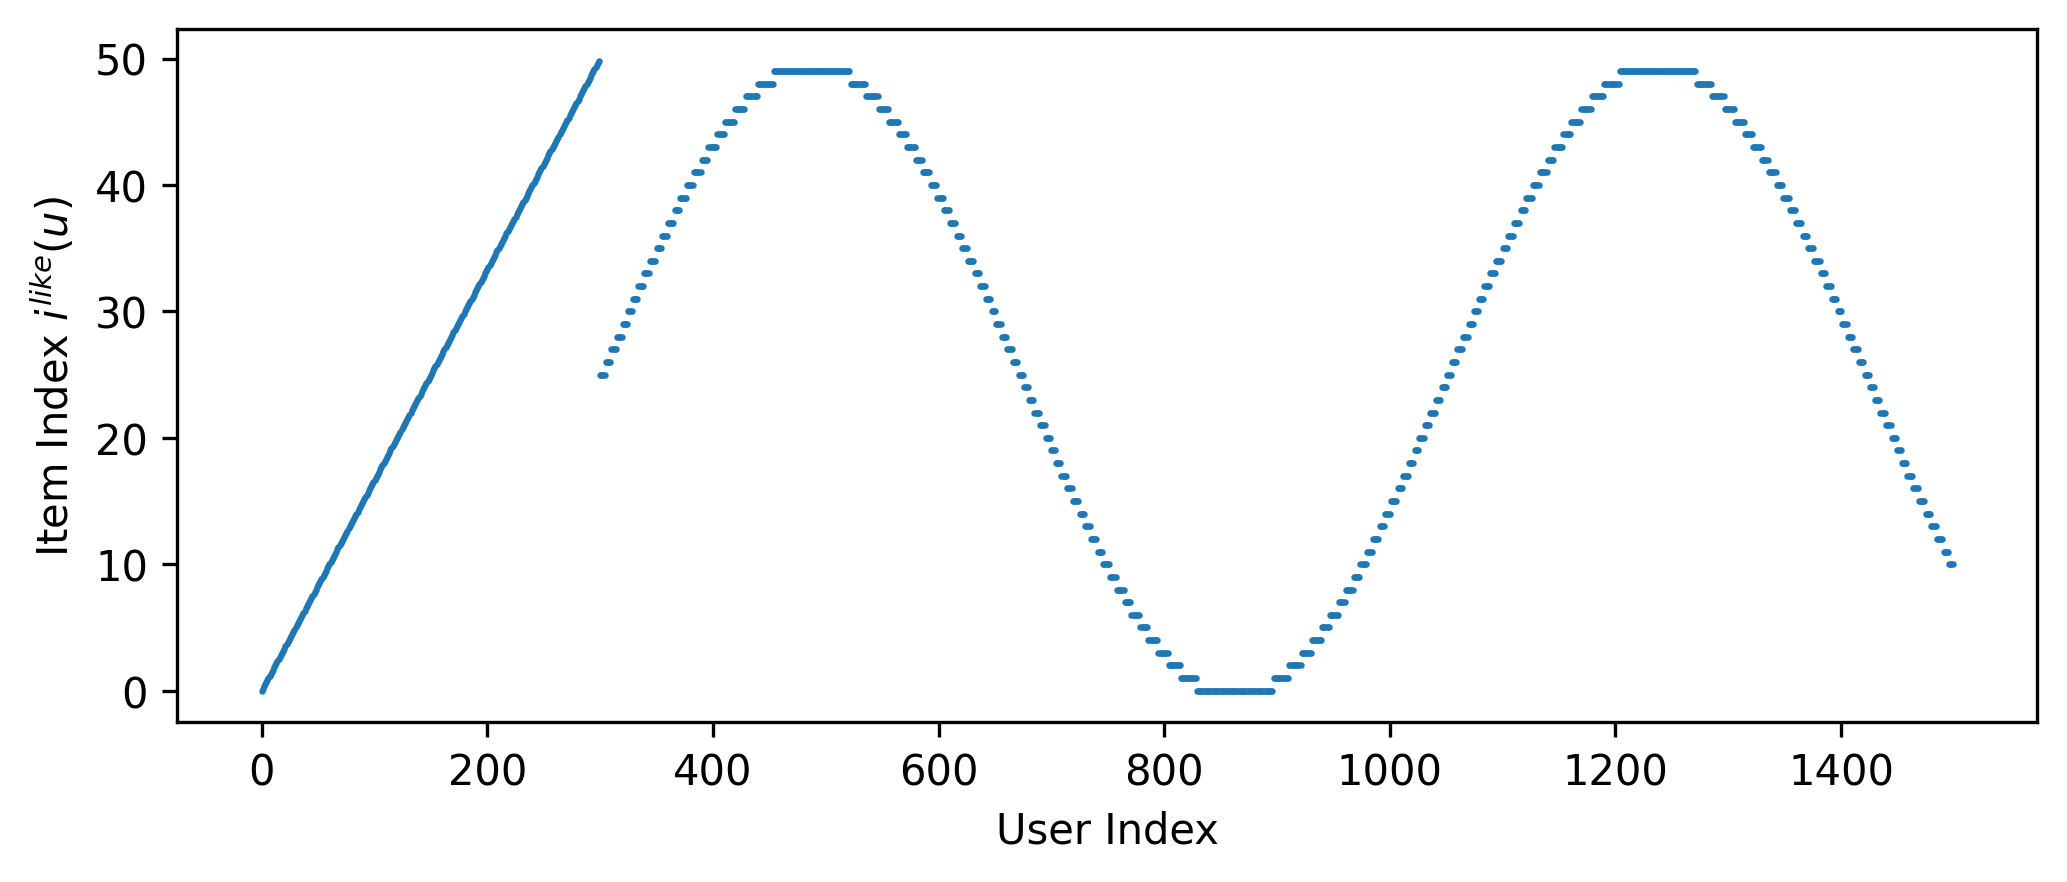

In [25]:
Is = np.sin(np.arange(int(0.8*num_users)) / num_users * 4 * np.pi)
Is = (Is + 1) / 2 * num_items
Is = Is.astype(int)

Us = np.arange(num_users)
Is = np.concatenate([
    np.arange(int(0.2*num_users)) * num_items / (0.2*num_users),
    Is
])

PREFERENCE = dict((u, i) for (u, i) in zip(Us, Is))

# plot the preference
fig, ax = plt.subplots(figsize=(8, 3), dpi=DPI)
ax.scatter(Us, Is, s=0.3)
ax.set_xlabel('User Index')
ax.set_ylabel('Item Index $i^{like}(u)$')
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_3_user_preferences.png"), dpi=DPI, bbox_inches='tight')
fig.show()

In [26]:
item_index = torch.LongTensor(np.random.choice(num_items, size=data_size))
user_bin_cate = torch.zeros(num_users).long()
# group users into two categories.
user_bin_cate[:100] = 1
user_bin_cate[200:num_users // 2] = 1

for idx in range(data_size):
    # follows random behaviors.
    rnd = np.random.rand()
    if user_bin_cate[int(user_index[idx])] == 0:
        if rnd <= 0.5:
            # choose based on preference with a probability of 0.5.
            item_index[idx] = PREFERENCE[int(user_index[idx])]
    else:
        if rnd <= 0.5:
            # choose based on preference with a probability of 0.5.
            item_index[idx] = num_items - PREFERENCE[int(user_index[idx])] - 1

To have a visual inspection on the preference we added, we can plot a heat map indexed by (user, item) and visualize the frequency of bought items by each user. In the heat map below, each row represents the empirical distribution of items (x-axis) bought. Warmer color (red) indicates high purchasing frequencies, which shows the synthetic sin-curve of preference we enforced above.

/tmp/ipykernel_22399/2592746616.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = df.pivot('item', 'user', 'size').fillna(0.0)


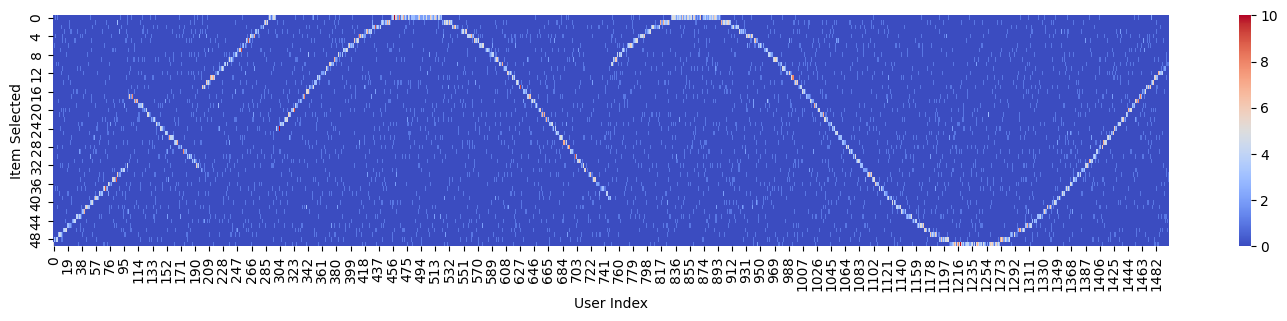

In [27]:
df = pd.DataFrame(data={'item': item_index, 'user': user_index}).groupby(['item', 'user']).size().rename('size').reset_index()
df = df.pivot('item', 'user', 'size').fillna(0.0)

fig, ax = plt.subplots(figsize=(18, 3))
sns.heatmap(df.values, square=False, ax=ax, cmap='coolwarm')
ax.set(xlabel='User Index', ylabel='Item Selected')
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_3_heatmap.png"), dpi=DPI, bbox_inches="tight")
fig.show()

In [28]:
# user_obs = torch.eye(num_users)
# user_obs = user_bin_cate.view(-1, 1)
# user_obs = torch.zeros(num_users, num_items)
# for u in range(num_users):
#     x = int(PREFERENCE[u])
#     if user_bin_cate[u] == 0:
#         user_obs[u, x] = 1
#     else:
#         user_obs[u, num_items - x - 1] = 1
# user_obs[torch.arange(num_users), Is] = 1
dataset_3 = ChoiceDataset(user_index=user_index, item_index=item_index, user_obs=torch.eye(num_users))

No `session_index` is provided, assume each choice instance is in its own session.


In [29]:
def fit_model(obs2prior: bool):
    LATENT_DIM = 5  # the dimension of alpha and theta.
    bemb = LitBEMBFlex(
        learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO.
        utility_formula='theta_user * alpha_item',  # the utility formula.
        num_users=num_users,
        num_items=num_items,
        num_user_obs=dataset_3.user_obs.shape[1],
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'theta_user': obs2prior, 'alpha_item': False},
        # the dimension of latents, since the utility is an inner product of theta and alpha, they should have
        # the same dimension.
        coef_dim_dict={'theta_user': LATENT_DIM, 'alpha_item': LATENT_DIM}
    )

    # use GPU if available.
    if torch.cuda.is_available():
        bemb = bemb.to('cuda')
       
    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb = bemb.fit_model(split_dataset_into_train_val_test(dataset_3),
                          batch_size=128, num_epochs=100, num_workers=0, device=DEVICE, enable_progress_bar=False)

    # visualize the prediction.
    T = bemb.model.coef_dict['theta_user'].variational_mean_flexible.data
    A = bemb.model.coef_dict['alpha_item'].variational_mean_flexible.data
    fig, ax = plt.subplots(figsize=(18, 3))
    sns.heatmap((A @ T.T).numpy(), square=False, ax=ax, cmap='coolwarm')
    if obs2prior:
        ax.set_title("User-Item Interaction Utility with Obs2Prior")
    else:
        ax.set_title("User-Item Interaction Utility without Obs2Prior")
    fig.savefig(os.path.join(OUTPUT_DIR, f"simulation_3_interaction_hat_obs2prior={obs2prior}.png"), dpi=DPI, bbox_inches="tight")
    fig.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 30.5 K
-----------------------------------
30.5 K    Trainable params
0         Non-trainable params
30.5 K    Total params
0.122     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['theta_user', 'alpha_item'], 'observable': None}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = theta_user * alpha_item
Total number of parameters: 30500.
With the following coefficients:
ModuleDict(
  (theta_user): BayesianCoefficient(num_classes=1500, dimension=5, prior=N(H*X_obs(H shape=torch.Size([5, 1500]), X_obs shape=1500), Ix1.0))
  (alpha_item): BayesianCoefficient(num_classes=50, dimension=5, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(label=[], item_index=[8000], user_index=[8000], session_index=[8000], item_availability=[], user_obs=[1500, 1500], device=cpu)
[Validation dataset] ChoiceDataset(label=[], item_index=[1000], user_index=[1000], session_index=[1000], item_availability=[], user_obs=[1500, 1500], device=cpu)
[Testing dataset] ChoiceDataset(label=[],

/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.

time taken: 62.982523918151855
==================== test performance ====================


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.284           │
│          test_ll          │    -4.053789083855227     │
└───────────────────────────┴───────────────────────────┘

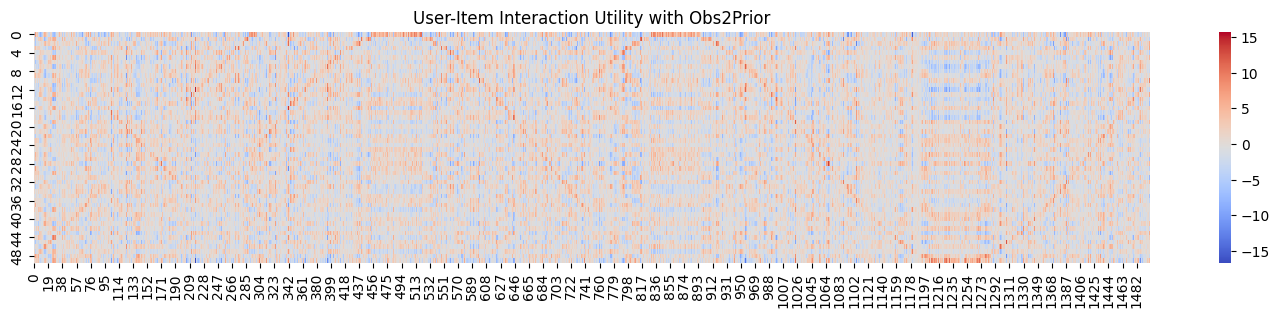

In [30]:
fit_model(obs2prior=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 15.5 K
-----------------------------------
15.5 K    Trainable params
0         Non-trainable params
15.5 K    Total params
0.062     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['theta_user', 'alpha_item'], 'observable': None}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = theta_user * alpha_item
Total number of parameters: 15500.
With the following coefficients:
ModuleDict(
  (theta_user): BayesianCoefficient(num_classes=1500, dimension=5, prior=N(0, I))
  (alpha_item): BayesianCoefficient(num_classes=50, dimension=5, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(label=[], item_index=[8000], user_index=[8000], session_index=[8000], item_availability=[], user_obs=[1500, 1500], device=cpu)
[Validation dataset] ChoiceDataset(label=[], item_index=[1000], user_index=[1000], session_index=[1000], item_availability=[], user_obs=[1500, 1500], device=cpu)
[Testing dataset] ChoiceDataset(label=[], item_index=[1000], user_index=[1000], session_index=[1000]

/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=100` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.

time taken: 58.35726451873779
==================== test performance ====================


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.042           │
│          test_ll          │    -3.9120112688541413    │
└───────────────────────────┴───────────────────────────┘

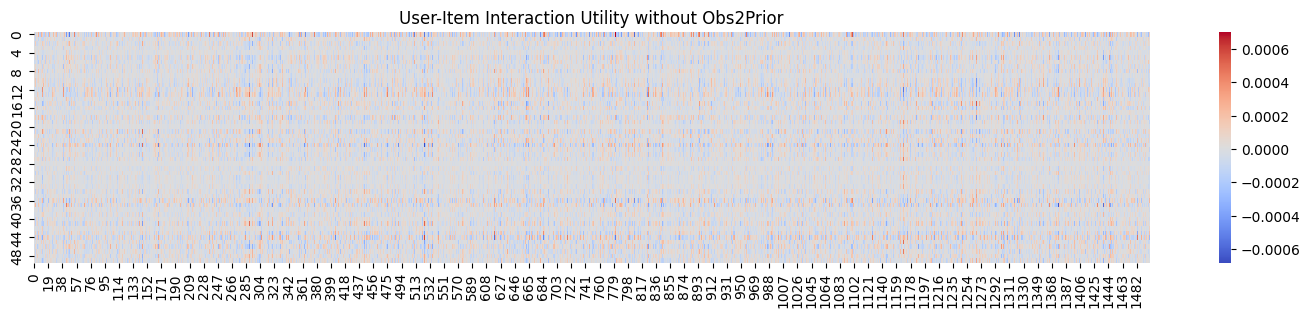

In [31]:
fit_model(obs2prior=False)

# Simulation Study 4: User Latent and Item Latent Coefficient

In [32]:
magnitude = 5
theta = torch.empty(num_users, num_items)
for u in range(num_users):
    for i in range(num_items):
        diff = np.abs(i - (PREFERENCE[u])) / 100
        theta[u, i] = 1/(1 + np.exp(-diff))
        theta[u, i] = magnitude * theta[u, i] - 2.8

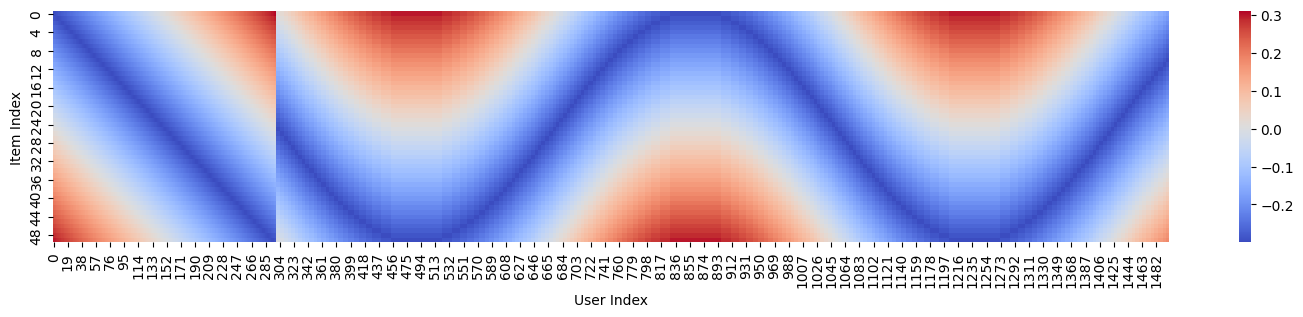

In [33]:
fig, ax = plt.subplots(figsize=(18, 3))
sns.heatmap(theta.T, square=False, ax=ax, cmap='coolwarm')
ax.set(xlabel='User Index', ylabel='Item Index')
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_4_coefficients.png"), dpi=DPI, bbox_inches="tight")
fig.show()

In [34]:
# generate random session observables.
session_obs = (torch.randn(num_sessions) + 1) * 100

In [35]:
# recompute utilities.
utility = torch.zeros(num_users, num_items, num_sessions)
for u in tqdm(range(num_users)):
    for i in range(num_items):
        for s in range(num_sessions):
            utility[u, i, s] = theta[u, i] * session_obs[s]

# sample random choices as before.
item_index = torch.empty(data_size, dtype=torch.long)
for idx in tqdm(range(data_size)):
    u = user_index[idx]
    s = session_index[idx]
    utility_list = utility[u, :, s]
    p = torch.softmax(utility_list, dim=0).numpy()
    item_chosen = np.random.choice(num_items, p=p)
    item_index[idx] = item_chosen

# report most bought and least bought items.
report_most_least_bought_items(item_index)

100%|██████████| 10000/10000 [00:00<00:00, 27669.54it/s]

Most bought item with their frequencies:
item
0       0.4339
49      0.2849
1       0.0736
48      0.0544
2       0.0227
dtype: float64
Least bought item with their frequencies:
item
19      0.0013
16      0.0013
11      0.0012
9       0.0012
24      0.0011
dtype: float64


In [36]:
user_obs = torch.zeros(num_users, num_items)
user_obs[torch.arange(num_users), Is] = 1

In [37]:
dataset_4 = ChoiceDataset(
    user_index=user_index,
    item_index=item_index,
    user_obs=user_obs,
    item_obs=item_obs,
    session_index=session_index,
    session_obs=session_obs.view(num_sessions, 1))

In [38]:
def fit_model(obs2prior: bool):
    LATENT_DIM = 5  # the dimension of alpha and theta.
    bemb = LitBEMBFlex(
        learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO.
        utility_formula='theta_user * alpha_item * session_obs',  # the utility formula.
        num_users=num_users,
        num_items=num_items,
        num_sessions=num_sessions,
        num_user_obs=dataset_4.user_obs.shape[1],
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'theta_user': obs2prior, 'alpha_item': False},
        # the dimension of latents, since the utility is an inner product of theta and alpha, they should have
        # the same dimension.
        coef_dim_dict={'theta_user': LATENT_DIM, 'alpha_item': LATENT_DIM}
    ).to(DEVICE)
       
    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb = bemb.fit_model(split_dataset_into_train_val_test(dataset_4),
                          batch_size=128, num_epochs=300, num_workers=0, device=DEVICE, enable_progress_bar=False)

    # visualize the prediction.
    T = bemb.model.coef_dict['theta_user'].variational_mean_flexible.data
    A = bemb.model.coef_dict['alpha_item'].variational_mean_flexible.data
    fig, ax = plt.subplots(figsize=(18, 3))
    sns.heatmap((A @ T.T).numpy(), square=False, ax=ax, cmap='coolwarm')
    if obs2prior:
        ax.set_title("User-Item Interaction Utility with Obs2Prior")
    else:
        ax.set_title("User-Item Interaction Utility without Obs2Prior")
    fig.savefig(os.path.join(OUTPUT_DIR, f"simulation_4_interaction_hat_obs2prior={obs2prior}.png"), dpi=DPI, bbox_inches="tight")
    fig.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 16.0 K
-----------------------------------
16.0 K    Trainable params
0         Non-trainable params
16.0 K    Total params
0.064     Total estimated model params size (MB)
/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, do

BEMB: utility formula parsed:
[{'coefficient': ['theta_user', 'alpha_item'], 'observable': 'session_obs'}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = theta_user * alpha_item * session_obs
Total number of parameters: 16000.
With the following coefficients:
ModuleDict(
  (theta_user): BayesianCoefficient(num_classes=1500, dimension=5, prior=N(H*X_obs(H shape=torch.Size([5, 50]), X_obs shape=50), Ix1.0))
  (alpha_item): BayesianCoefficient(num_classes=50, dimension=5, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(label=[], item_index=[8000], user_index=[8000], session_index=[8000], item_availability=[], user_obs=[1500, 50], item_obs=[50, 2], session_obs=[10, 1], device=cpu)
[Validation dataset] ChoiceDataset(label=[], item_index=[1000], user_index=[1000], session_index=[1000], item_availability=[], user_obs=[1500, 50],

`Trainer.fit` stopped: `max_epochs=300` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tianyudu/anaconda3/envs/dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


time taken: 147.24073934555054
==================== test performance ====================


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │           0.711           │
│          test_ll          │    -1.0611618126890972    │
└───────────────────────────┴───────────────────────────┘

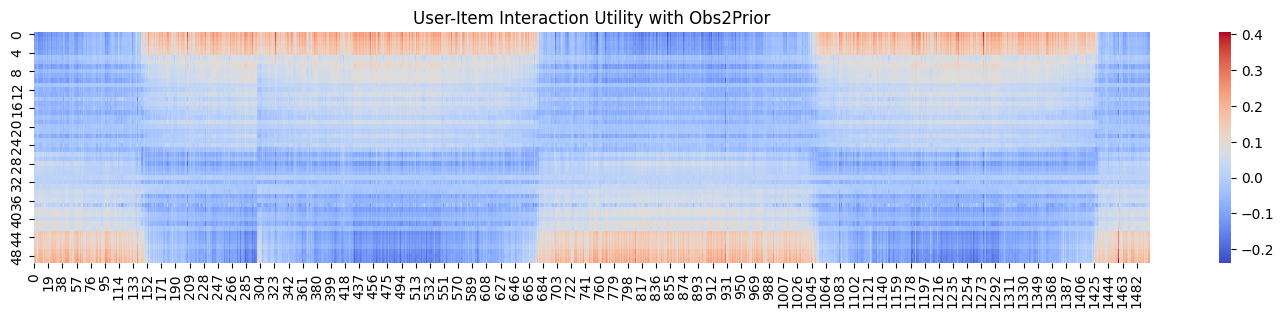

In [39]:
fit_model(obs2prior=True)